In [2]:
# Show the figures / plots inside the notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
mouth_cascade = cv2.CascadeClassifier('./haar/haarcascade_smile.xml')

# if mouth_cascade.empty():
#   raise IOError('Unable to load the mouth cascade classifier xml file')



Utility functions

In [22]:
def show_hist(image, title, ignore_first=1):
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    peaks_indices = get_peaks(hist, image)
    print(peaks_indices)
    # Ignore the first 'ignore_first' values in the histogram
    hist[0:ignore_first] = 0

    # Plot the modified histogram
    plt.plot(hist, color='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def remove_background(image, rectangle, iterations=5):
    #This line creates an empty binary mask with the same dimensions as the input image 
    #The mask is initially filled with zeros, indicating that no pixels are currently classified as either foreground or background.
    mask = np.zeros(image.shape[:2], np.uint8)
    cv2.grabCut(image, mask, rectangle, None, None, iterations, cv2.GC_INIT_WITH_RECT)

    #if mask is 2 or 0, it is converted to 0, otherwise converted to 1
    #2 or 0 means background, 1 or 3 means foreground
    mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    #converting the input image to grayscale and applying the mask
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = img * mask

    return img

def divide_image(image):
    img = image.copy()

    #this function takes an image and divide it into 4 parts
    part1 = img[0:img.shape[0]//2, 0:img.shape[1]//2]
    part2 = img[0:img.shape[0]//2, img.shape[1]//2:img.shape[1]]
    part3 = img[img.shape[0]//2:img.shape[0], 0:img.shape[1]//2]
    part4 = image[img.shape[0]//2:img.shape[0], img.shape[1]//2:img.shape[1]]

    return part1, part2, part3, part4

#this function takes an images and divide into 4 parts and calculate the histogram of each part
def local_hist(image):
    part1, part2, part3, part4 = divide_image(image)

    show_hist(part1, 'Histogram of part1')
    show_hist(part2, 'Histogram of part2')
    show_hist(part3, 'Histogram of part3')
    show_hist(part4, 'Histogram of part4')

#this function takes array of threshold values and an image and return the image after applying the threshold to each part
def local_thresholding(thresholds, image):
    # Create a copy of the image
    image_thresholded = np.copy(image)

    # Divide the image into 4 parts
    part1 = image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2]
    part2 = image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]]
    part3 = image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2]
    part4 = image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]]

    # Apply thresholding
    image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2] = np.where(part1 < thresholds[0], 0, 255)
    image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]] = np.where(part2 < thresholds[1], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2] = np.where(part3 < thresholds[2], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]] = np.where(part4 < thresholds[3], 0, 255)
    

    return image_thresholded

def get_peaks(hist, image):
    
    skin_color = image[0, 0]
    tooth_color = image[(image.shape[0]//2)-40, image.shape[1]//2]
    dist = abs(abs(tooth_color-skin_color)-50)

    #Here I am removing sharp teeth
    #the method is to remove peaks that are much higher than the neighboring peaks
    #I am calculating the difference between each peak and its left and right neighbors
    #if the difference is higher than a threshold, then I am removing this peak
    threshold = 100
    for i in range(1, len(hist)-1):
        if hist[i] > hist[i-1] and hist[i] > hist[i+1]:
            if abs(hist[i]-hist[i-1]) > threshold and abs(hist[i]-hist[i+1]) > threshold:
                hist[i] = 0

    peaks_indices, _ = find_peaks(hist.flatten(), distance=dist, height=0.4*max(hist.flatten()))
    return peaks_indices

def get_teeth_local(image):

    part1, part2, part3, part4 = divide_image(image)

    hist1 = cv2.calcHist([part1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([part2], [0], None, [256], [0, 256])
    hist3 = cv2.calcHist([part3], [0], None, [256], [0, 256])
    hist4 = cv2.calcHist([part4], [0], None, [256], [0, 256])

    peak1 = get_peaks(hist1, part1)
    peak2 = get_peaks(hist2, part2)
    peak3 = get_peaks(hist3, part3)
    peak4 = get_peaks(hist4, part4)

    return peak1, peak2, peak3, peak4

def get_threshold_between_2_peaks(peak1, peak2, img):
    #this function takes 2 peaks and the histogram and return the threshold between them
    #the threshold is the minimum value between the 2 peaks
    min_value = 255
    min_index = 0
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    for i in range(0, peak2-peak1):
        if hist[i] < min_value:
            min_value = hist[i]
            min_index = i

    return min_index + peak1 + 40
  

Reading the image and applying face detection using haar cascades

In [4]:
# Read the input image
image_path = './images/img_me2.jpg'
img = cv2.imread(image_path)

#resize image 716x900
img = cv2.resize(img, (716, 1000))


# Perform face detection
faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
cv2.imshow('Face Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()




Remove background using Grabcut algorithm


In [23]:
img_temp = img.copy()
# img_temp = remove_background(img, faces[0], iterations=5)

cv2.imshow("Foreground", img_temp)
cv2.waitKey(0)
cv2.destroyAllWindows()

Segmenting the mouth area from the face and applying gamma correction

[131]


C:\Users\mosmo\AppData\Local\Temp\ipykernel_17272\1764112045.py:76: RuntimeWarning: overflow encountered in scalar subtract
  dist = abs(abs(tooth_color-skin_color)-50)


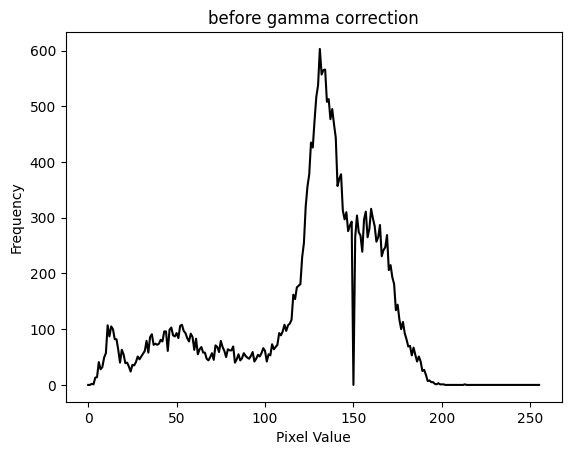

[131]


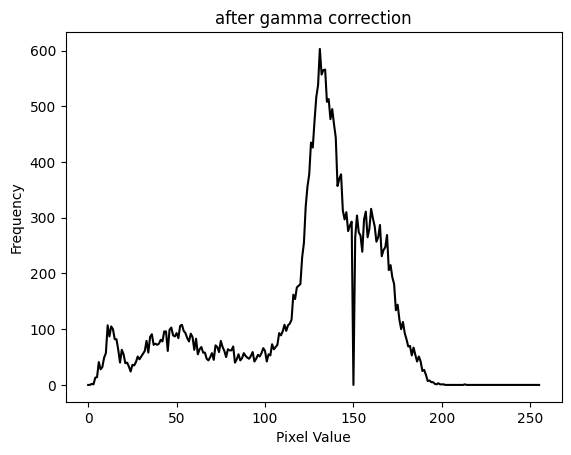

In [24]:
#segment the face
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)

for (x, y, w, h) in faces:
    #take the region of interest which is the face
    roi_gray = img_temp[y:y+h, x:x+w]
    
    #then take the mouth region only
    roi_gray_mouth_region = roi_gray[int(roi_gray.shape[0]/1.5):roi_gray.shape[0], int(roi_gray.shape[1]/4):int(roi_gray.shape[1]/4)+int(roi_gray.shape[1]/2)]

    cv2.imshow('mouth Segmentation before gamma correction', roi_gray_mouth_region)

    #plot histogram
    show_hist(roi_gray_mouth_region, "before gamma correction")
    
    #apply gamma correction
    gamma = 1
    roi_gray_mouth_region = np.array(255 * (roi_gray_mouth_region / 255) ** gamma, dtype = 'uint8')

    #plot histogram
    show_hist(roi_gray_mouth_region, "after gamma correction")
    
    cv2.imshow('mouth Segmentation after gamma correction', roi_gray_mouth_region)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

[ 53 163]


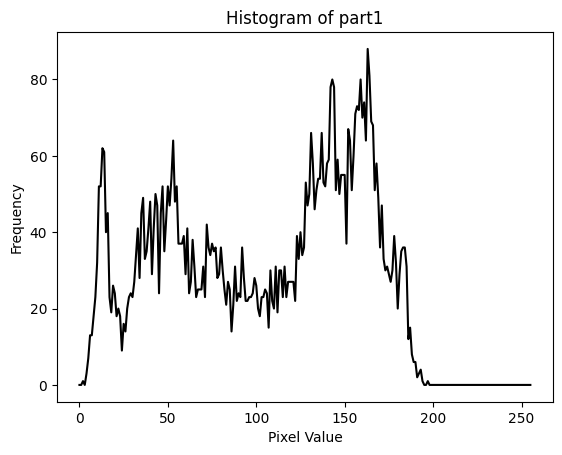

[ 11  58 140]


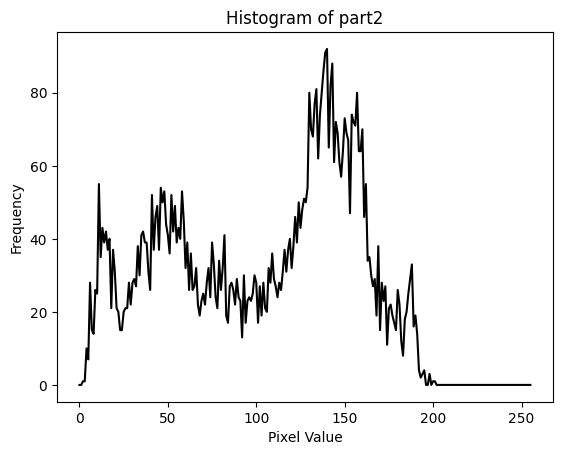

[131 169]


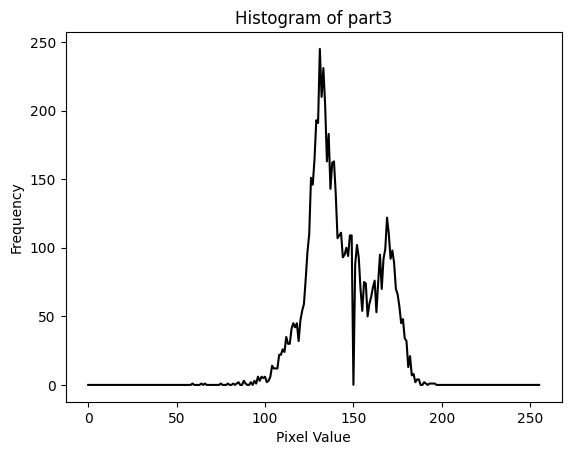

[134]


C:\Users\mosmo\AppData\Local\Temp\ipykernel_17272\2754808822.py:76: RuntimeWarning: overflow encountered in scalar subtract
  dist = abs(abs(tooth_color-skin_color)-50)


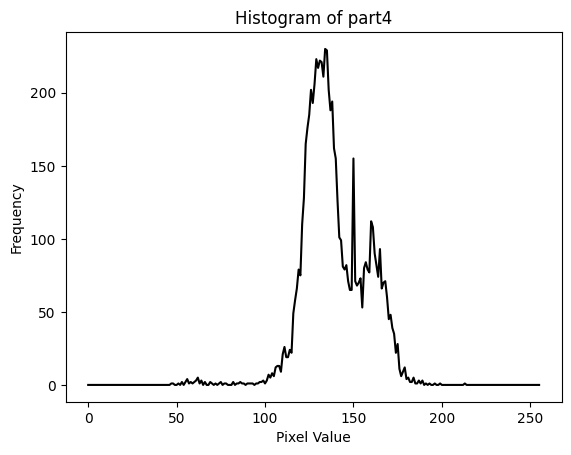

In [7]:
local_hist(roi_gray_mouth_region)


Applying segmentation using threshholding

In [25]:
max_value = np.max(roi_gray_mouth_region)
mean_value = np.mean(roi_gray_mouth_region)

#dividing the image into 4 parts and calculate the histogram of each part
part1, part2, part3, part4 = divide_image(roi_gray_mouth_region)
peak1, peak2, peak3, peak4 = get_teeth_local(roi_gray_mouth_region)

#puting the peaks in an array to make it easy to loop over them
hist_peaks = [peak1, peak2, peak3, peak4]
img_parts = [part1, part2, part3, part4]

for i in range(len(hist_peaks)):
    #if there is one peak only, then put hist_peaks[i] = 255
    if len(hist_peaks[i]) == 1:
        hist_peaks[i] = 255
    else:
        hist_peaks[i] = get_threshold_between_2_peaks(hist_peaks[i][0], hist_peaks[i][1], img_parts[i][0])


print(hist_peaks)
roi_gray_mouth_region = local_thresholding(hist_peaks, roi_gray_mouth_region)


cv2.imshow('After Threshholding', roi_gray_mouth_region)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\mosmo\AppData\Local\Temp\ipykernel_17272\1764112045.py:76: RuntimeWarning: overflow encountered in scalar subtract
  dist = abs(abs(tooth_color-skin_color)-50)


[93, 51, 171, 255]


Applying opening to remove noise

In [26]:
kernel = np.ones((5, 5), np.uint8)

# Apply opening operation to the binary mask
opened_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_OPEN, kernel)

roi_gray_mouth_region = roi_gray_mouth_region * opened_mask

cv2.imshow("Opened Mask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()

Applying dilation to take the whole mouth

In [27]:
kernel = np.ones((5, 5), np.uint8)

# # Define the dimensions of the ellipse (width and height)
# ellipse_width = 5
# ellipse_height = 10

# # Create an elliptical kernel
# ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ellipse_width, ellipse_height))


# Apply closing operation to the binary mask
dilate_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_DILATE, kernel, iterations=5)
roi_gray_mouth_region = cv2.bitwise_or(roi_gray_mouth_region, dilate_mask)

cv2.imshow("Opened Mask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()

Take the mouth from the original image

In [28]:
#Now we have the mouth region only
#We want to extract the lips from the orignal image
for (x, y, w, h) in faces:
    
    mouth_region = img[y+int(roi_gray.shape[0]/1.5):y+h, x+int(roi_gray.shape[1]/4):x+int(roi_gray.shape[1]/4)+int(roi_gray.shape[1]/2)] 

    #apply the mask to the mouth region
    #here we convert the mask to 3d to apply it to the mouth region
    #np.stack((roi_gray_mouth_region,) * 3, axis=-1) converts the mask to 3d in the last axis which is the color axis
    roi_gray_mouth_region_3d = np.stack((roi_gray_mouth_region,) * 3, axis=-1)
    mouth_region = mouth_region * roi_gray_mouth_region_3d
   
    cv2.imshow('mouth Segmentation', mouth_region)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Loading the second image

In [29]:
image2_path = './images/amin2.png'
img2 = cv2.imread(image2_path)

#resize image 716x900
img2 = cv2.resize(img2, (716, 1000))


# Perform face detection
faces2 = face_cascade.detectMultiScale(img2, scaleFactor=1.3, minNeighbors=5)



cv2.imshow('Face Detection 2', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

Apply the mask to the second image

In [30]:
for (x2, y2, w2, h2) in faces2:

    #take the region of interest which is the face
    roi2 = img2[y2:y2+h2, x2:x2+w2]
    
    #and here I am taking the mouth region only, which will help me to detect the mouth region in the second image using haar
    #haar cascade works better with small images, it doesn't work well with large images
    #so I am taking the mouth region only to detect the mouth region in the second image
    mouth2_region = roi2[int(roi2.shape[0]/1.5):roi2.shape[0], int(roi2.shape[1]/4):int(roi2.shape[1]/4)+int(roi2.shape[1]/2)]

    #using haar cascade to detect the mouth region
    mouth2 = mouth_cascade.detectMultiScale(mouth2_region, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

    for (mx2, my2, mw2, mh2) in mouth2:
        cv2.rectangle(mouth2_region, (mx2, my2), (mx2+mw2, my2+mh2), (0, 255, 0), 2)


    [mx2, my2, mw2, mh2] = mouth2[0]
    mouth2_region = mouth2_region[my2:my2+mh2, mx2:mx2+mw2]


    #resize the mouth region to the same size of the mouth region of the second image
    mouth_region_resized = cv2.resize(mouth_region, (mw2, mh2))
    roi_gray_mouth_region_resized = cv2.resize(roi_gray_mouth_region, (mw2, mh2))

    for i in range(mouth2_region.shape[0]):
        for j in range(mouth2_region.shape[1]):
            if roi_gray_mouth_region_resized[i][j] == 1:
                mouth2_region[i][j] = mouth_region_resized[i][j]

cv2.imshow('mouth2_region', mouth2_region)
cv2.imshow('Result', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()